In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Анализ данных одной метрики одной БД 

In [6]:
import os
print(os.listdir("./input"))

['sample2.csv', 'tablespace_data.csv', 'tablespace_original.csv']


In [27]:
sample = pd.read_csv('./input/sample2.csv', sep='\t')
sample['rollup_timestamp'] = pd.to_datetime(sample['rollup_timestamp'])

In [28]:
sample.head()

,rollup_timestamp,database,value
0,2018-06-01,8237bf33-d19c-4910-9206-c6d43f0b498f,549.0
1,2018-06-02,8237bf33-d19c-4910-9206-c6d43f0b498f,527.0
2,2018-06-03,8237bf33-d19c-4910-9206-c6d43f0b498f,55.0
3,2018-06-04,8237bf33-d19c-4910-9206-c6d43f0b498f,502.0
4,2018-06-05,8237bf33-d19c-4910-9206-c6d43f0b498f,625.0


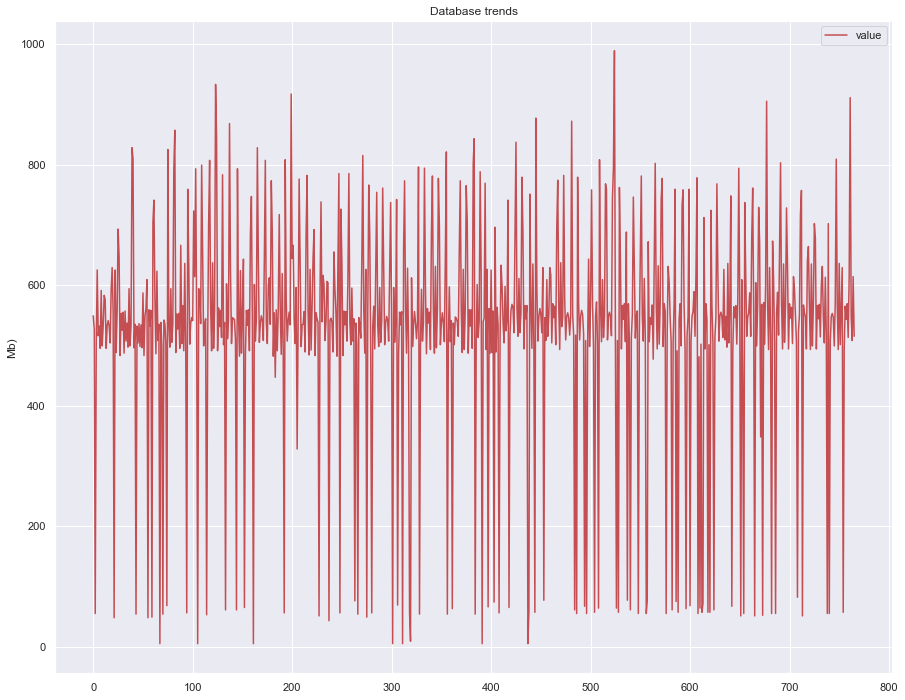

In [20]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['value'], 'r-', label = 'value')
plt.title('Database trends')
plt.ylabel('Mb)');
plt.legend();
plt.show()

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [29]:
sample.set_index('rollup_timestamp', inplace=True)

In [30]:
sample.index

DatetimeIndex(['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04',
               '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08',
               '2018-06-09', '2018-06-10',
               ...
               '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29',
               '2020-06-30', '2020-07-01', '2020-07-02', '2020-07-03',
               '2020-07-04', '2020-07-05'],
              dtype='datetime64[ns]', name='rollup_timestamp', length=766, freq=None)

In [31]:
#усреднение за месяц
sample_month = sample['value'].resample('MS').mean()

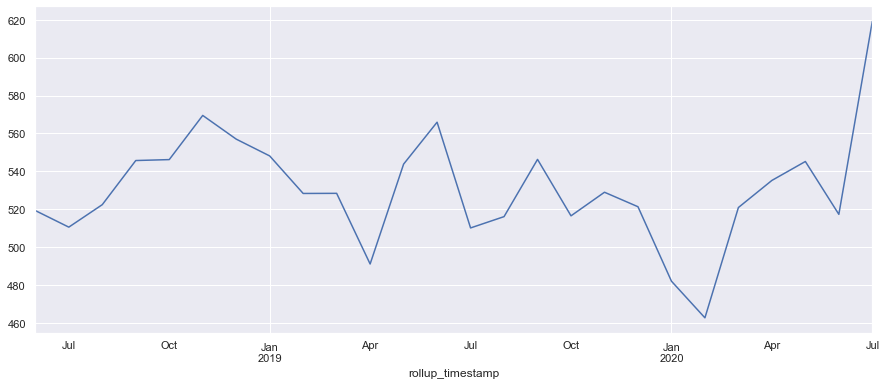

In [32]:
sample_month.plot(figsize=(15, 6))
plt.show()

Text(0.5, 1.0, 'detrended by subtracting the least squares fit')

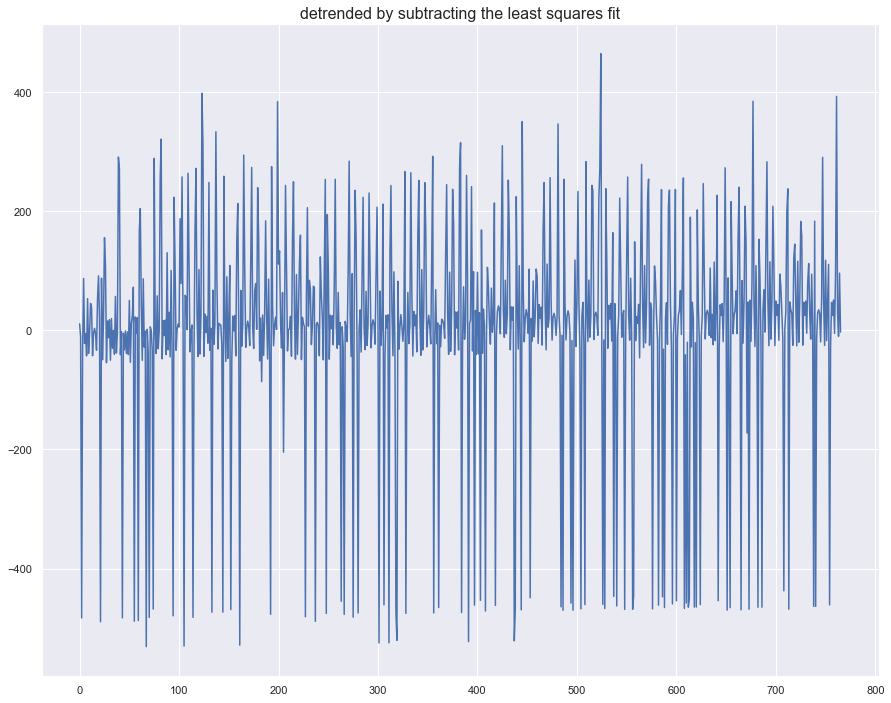

In [52]:
# с помощью scipy убираем компонент тренда, чтобы показать колебания
from scipy import signal
detrended = signal.detrend(sample.value.values)
plt.figure(figsize=(15, 12))
plt.plot(detrended)
plt.title('detrended by subtracting the least squares fit', fontsize=16)

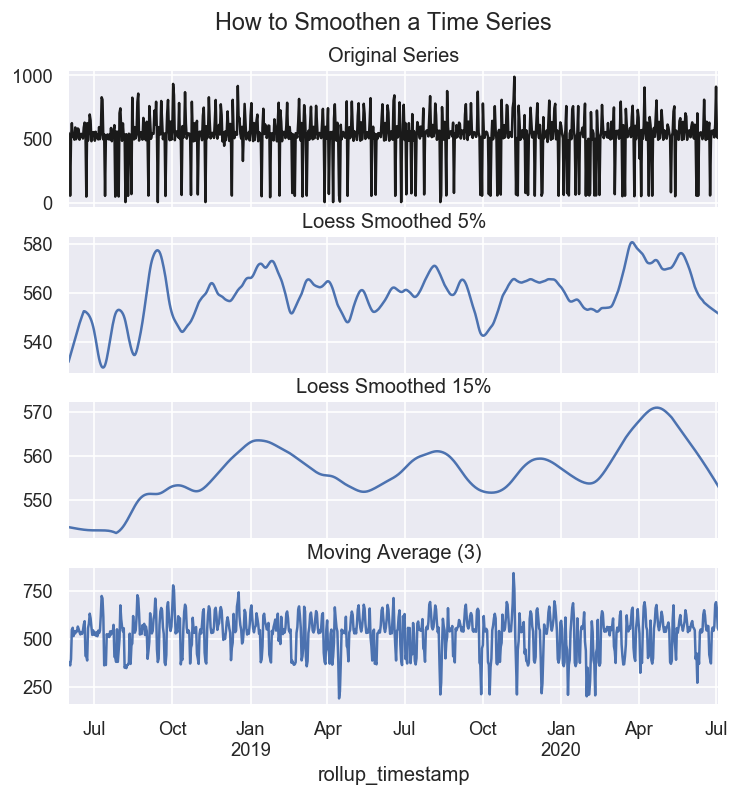

In [37]:
# сглаживания для наглядной визуализации
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# бегущее среднее
sample_ma = sample.value.rolling(3, center=True, closed='both').mean()

# локальная регрессия (5% и 15%)
sample_loess_5 = pd.DataFrame(lowess(sample.value, np.arange(len(sample.value)), frac=0.05)[:, 1], index=sample.index, columns=['value'])
sample_loess_15 = pd.DataFrame(lowess(sample.value, np.arange(len(sample.value)), frac=0.15)[:, 1], index=sample.index, columns=['value'])

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
sample['value'].plot(ax=axes[0], color='k', title='Original Series')
sample_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
sample_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
sample_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

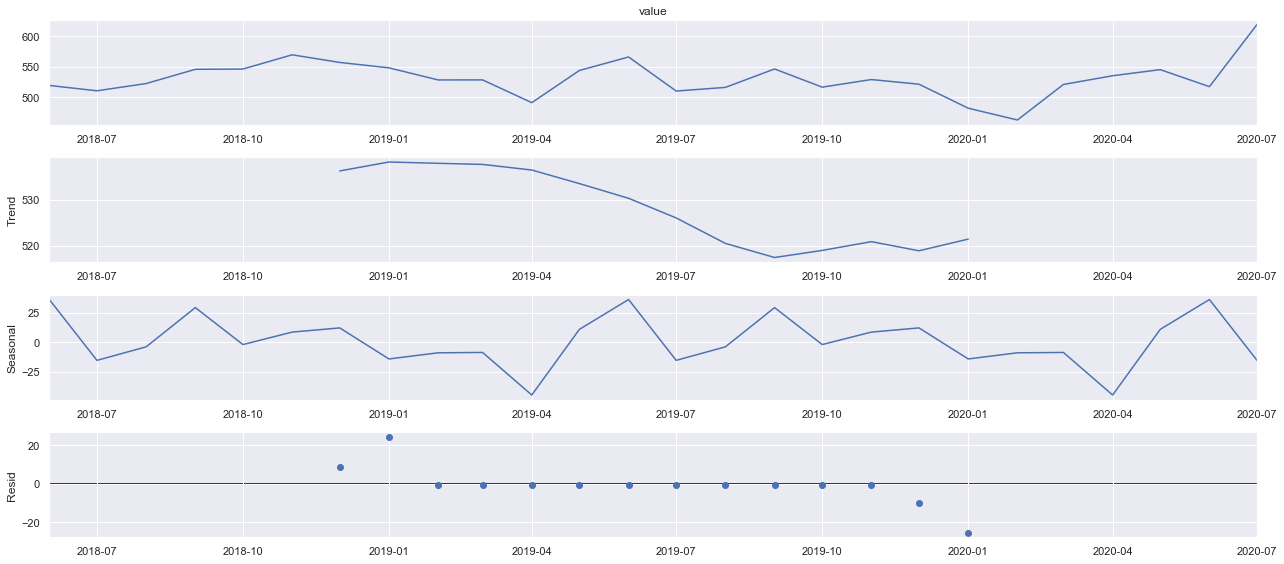

In [38]:
# извлечение тренда, сезонности и шума
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sample_month, model='additive')
fig = decomposition.plot()
plt.show()

## Autoregressive Integrated Moving Average
ARIMA models are denoted with the notation ARIMA(p, d, q) - three parameters account for seasonality, trend, and noise in data
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [39]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [44]:
min = 9999
min_param = 0
min_param_seasonal = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sample_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min:
                min = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:386.7838011660537
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:199.8622347575178
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:139.02063870063907
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:16.221260150967765
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:151.09573296838076


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:142.0092006232274
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:27.040034121483004


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7.6365102370328755
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:373.8268095911724


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:187.71531947118655
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:129.7163607065625
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:152.21344068584693


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:134.4541744980638
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:28.733435070369865
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:239.96865323421696
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:123.90737281212614
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:132.55521545658675
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:136.5052310767147
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:124.33881213027429


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:230.27112687868583
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:117.91418457388096
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:122.83048907608386
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:137.28757399302006
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:118.76862079519859


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:250.70126134953279
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:136.8602184230923
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:140.60393430000335


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-5.563763085698589
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:141.98452437843764
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:137.91155703523188


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-1.5848425638352328
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-6.028782418500345
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:241.05908186818567
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:128.62381746739027
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:131.64836725808516
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:143.9788204286888
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:129.26774669881848
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:0.41946026942628745
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:240.47697801492063
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:125.45724939172536
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:134.04133953142923
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:125.92940418578624
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:126.33861095160952
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:230.8325045411516
ARIMA(1, 1

In [45]:
print('ARIMA{}x{}12 - AIC:{}'.format(min_param, min_param_seasonal, min))
# минимально ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:131.89208206778764

ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-6.028782418500345


In [46]:
mod = sm.tsa.statespace.SARIMAX(sample_month,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2362   9.04e-10  -2.47e+09      0.000      -2.236      -2.236
ar.S.L12       0.0028   1.93e-09   1.43e+06      0.000       0.003       0.003
ma.S.L12      -1.5317   2.01e-15  -7.61e+14      0.000      -1.532      -1.532
sigma2       2.46e-08   8.92e-08      0.276      0.783    -1.5e-07    1.99e-07


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3053: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tools\eval_measures.py:394: Runtime

ValueError: operands could not be broadcast together with shapes (9,) (7,) (9,) 

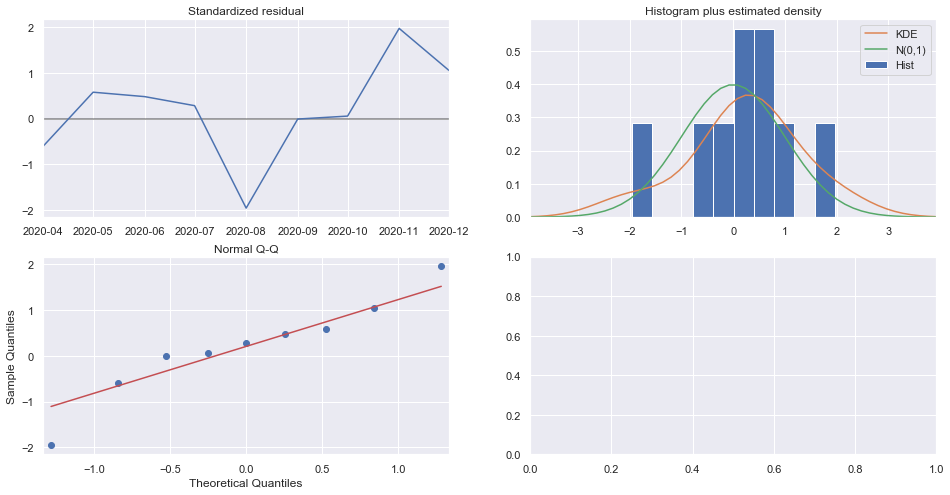

In [70]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

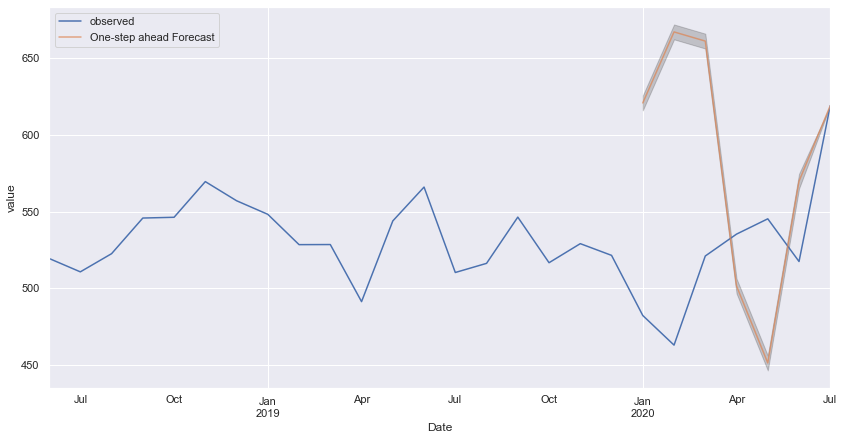

In [48]:
#предсказания с начала 2020 и сравнение с рельными данными
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sample_month['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

## Оценка ошибки

In [49]:
sample_month_forecasted = pred.predicted_mean
sample_month_truth = sample_month['2020-01-01':]
mse = ((sample_month_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

NameError: name 'y_truth' is not defined

In [84]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 471.5


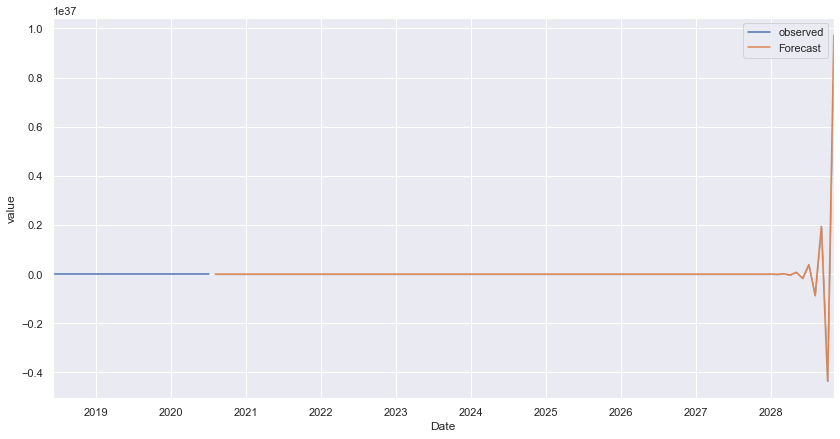

In [51]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = sample_month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()